---

# The engine of neural networks: Gradient-based optimization

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo

Each neural layer performs `activation(dot(w, x) + b)`.

But what are the optimal values of `w` and `b` for a particular problem?

We have seen an example of **training**, allowing the network to find those.

<!-- <img src="images/chollet/figure1.9.png" style="height: 400px"> -->
<img style="height: 400px;" src="https://raw.githubusercontent.com/jchwenger/AI/main/2-building-blocks/images/chollet/figure1.9.png">

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter01_what-is-deep-learning/), Chapter 1, Figure 1.9</small>

#### Note

The training loop either terminates (reaching the specified number of epochs) or is interrupted (manually).

💀 There is **no universal formula** for when to stop. (This is an active area of research.)

Practitioners tend to save various versions along the way, keeping the best-performing one.

### Gradient descent: our compass

  - We want to minimise our loss function;
  - The output of the loss function can be viewed as the **ground height** in a **multidimensional landscape (the input space)** – this is computed for **each** sample;
  - The value of all the weights and biases define a **coordinate** in this landscape;
  - The **gradient** gives us the **direction of steepest ascent**: it tells us how to tweak parameters so as to increase our loss the most;
  - Going the opposite way is like **taking a step downward** on the **landscape** of the loss function.

### Backpropagation: our gradient engine

But then, we want to know which parameters change our loss the most, to lower our loss as much as possible.

By calculating the derivative of **each operation** with respect to the loss, we know how much each of them **affects** the loss.

And so by how much we need to change each parameter in order to lower the overall loss the most effectively.

##### Note

**Everything must be smooth and differentiable**, so we can precisely compute the influence of every operation on the final loss.

## What do we need now?

1. **Derivatives**
2. Derivatives for tensors: the gradient
3. Optimization: stochastic gradient descent, momentum
4. Chaining derivatives: the backpropagation algorithm

---

## What's a derivative?

A smooth function $f$ is a function without abrupt changes.

$f$ in the vicinity of a point $x$ can always be approximated:

\begin{align*}
f(x + \delta x) \approx f(x) + m \delta x
\end{align*}

where $m$ is the gradient of the tangent at $x$ and $\delta x$ is a small step.

<!-- ![derivative.png](images/derivative.png) -->
<img style="" src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/derivative.png?raw=true">

The gradient of differentiable functions – those without abrupt changes – is calculable from simple rules.

Here are differentiation rules:


|$f$ |$\frac{df}{dx}$ | |
|:---|:---|:---|
|$x^n$|$nx^{n-1}$| Power |
|$g(x) + h(x)$ | $\frac{dg}{dx} + \frac{dh}{dx}$| Linearity |
|$af(x)$ | $a\frac{df}{dx}$ | Linearity |
|$f(y(x))$ | $\frac{df}{dy}\frac{dy}{dx}$ | Chain rule |



Here are some differentiation examples:

|$f$ |$\frac{df}{dx}$ | |
|:---|:---|---|
| $5x^3$ | $15 x^2$ | |
| $5x^2 - 2x + 3$ | $10x - 2$ | |
| $(3x + 2x^2)^2$ | $2(3x + 2x^2)(3 + 4x)$ | chain rule!  |

$$\color{red}{(}\color{green}{3x + 2x^2}\color{red}{)^2}$$

can be written as a composition:

\begin{align*}
f &= \color{red}{y^2} \color{black}{\text{ where}}\\
y &= \color{green}{3x + 2x^2}  \\
\end{align*}

$f$ is differentiated with respect to $y$, and then $y$ is differentiated with respect to $x$:

\begin{align*}
\frac{df}{dx} &= \color{red}{\frac{df}{dy}}\color{green}{\frac{dy}{dx}} \\
               &= \color{red}{2y}   \color{green}{(3 + 4x)} \\
               &= \color{red}{2(3x + 2x^2)}\color{green}{(3 + 4x)}
\end{align*}

##### Note

Complex derivatives (compositions of functions) can be broken down into simpler ones!

TensorFlow is meant to automate all that.

TensorFlow can track operations and calculate gradients with the `GradientTape` object.

Then, the method `tape.gradient(df, dx)` takes a function and a point and returns the gradient.

Let's start with a super simple example, the gradient function of $f(x) = x^2$ is $f'(x) = 2x$.

The gradient at $x = 3$ is $6$.

In [2]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:  # GradientTape means: "please please record operations and please calculate
    f = x**2                     # all derivatives automatically for me!"
                                 # https://www.tensorflow.org/api_docs/python/tf/GradientTape
df_dx = tape.gradient(f, x) # x can also be an array of variables
print(df_dx.numpy())

6.0


## Next

1. Derivatives
2. **Derivatives for tensors: the gradient**
3. Optimization: stochastic gradient descent, momentum
4. Chaining derivatives: the backpropagation algorithm

---

## Derivative of a tensor operation: the gradient

But the loss function is tensor-valued...

What is the derivative of a tensor operation?

Here's our affine transformation from last time.

\begin{eqnarray}
y = \left(\begin{array}{c} y_1 \\
                       y_2 \end{array} \right)
=
\left( \begin{array}{c} w_{11} & w_{12} \\
                        w_{21} & w_{22} \end{array} \right)
\left( \begin{array}{c} x_1  \\
                        x_2  \end{array}  \right)
+
\left( \begin{array}{c} b_1  \\
                        b_2         \end{array}  \right)
\end{eqnarray}

For example:
\begin{eqnarray}
\left( \begin{array}{c} 1 & -2 \\
                                 2 & 1  \end{array}  \right)
\left( \begin{array}{c} 1  \\
                        2  \end{array}  \right)
+
\left( \begin{array}{c} 0  \\
                        -1\end{array}  \right)
=
\left( \begin{array}{c}-3  \\
                        3         \end{array}  \right)
\end{eqnarray}


                   

In [3]:
w = tf.Variable([
    [1., -2.],
    [2.,  1.]
])
b = tf.Variable([
    [ 0.],
    [-1.]
])
x = tf.Variable([
    [1.],
    [2.]
])

y = w @ x + b # @ is the matrix multiplication operator

print(y.numpy())

[[-3.]
 [ 3.]]


The gradient of a two variable function, $f = f(x, y)$, with respect to either variable, is written $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}...$ (with 'curly' d's).

We almost have all we need to explain automatic gradient descent – how the optimiser tweaks layer weights and biases in an efficient implementation known as backpropagation.

The final bit of theory is **partial differentiation**.

Partial differentiation means the differentiation of a function of several variables.


Here, $f$ is a function of two variables.

Differentiation follows the single-variable rules.

The **undifferentiated variable is held constant**:

| $f$|$\frac{\partial f}{\partial x}$ |$\frac{\partial f}{\partial y}$ |
|:---|:---|:---|
|$xy$|$y$| $x$ |
| $ax^n + by^m$|$anx^{n-1}$| $bmy^{m-1}$ |

These are literally the same the rules for one variable.

Suppose we have a very simple network that implements a single 2D affine transformation.

\begin{align*}\\
Input&:\ (x_1, x_2)\\
Prediction&:\ (y_1, y_2)\\
Target&:\ (0, 0)\\
\bf{Loss}&:\ (y_1 - 0)^2 + (y_2 - 0)^2 = \mathbf{y_1^2 + y_2^2}\ \leftarrow squared\ distance
\end{align*}

We wish to adjust the weights in order to lower the loss on the input $(1, 2)^T$.

We need to find the gradients in $w, b$-space.

We must differentiate with respect to $w_{11}, w_{12}, w_{21}, w_{22}, b_1, b_2$.

\begin{align*}
y_1 &= w_{11}x_1 + w_{12}x_2 + b_1 \\
y_2 &= w_{21}x_1 + w_{22}x_2  + b_2 \\
\\
J^* &= y_1^2 + y_2^2 &\\
  &= (w_{11}x_1 + w_{12}x_2 + b_1)^2 + (w_{21}x_1 + w_{22}x_2  + b_2)^2
\end{align*}

\* **_J_** is commonly used for the loss (think:ob*J*ective? It actually comes from the [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), the matrix of partial derivatives of a vector-valued function).

The loss is a fairly horrible function of the weights and biases. Here for $w_{11}$:

\begin{align*}
\frac{\partial J}{\partial w_{11}} &= \frac{\partial J}{\partial y_1} \frac{\partial y_1}{\partial w_{11}}\ &&|\ J = y_1^2 + y_2^2 \\
                                   &= \frac{\partial (\color{red}{y_1^2} + \color{blue}{y_2^2})}{\partial y_1}  \frac{\partial y_1}{\partial w_{11}}\ &&|\ only\ y_1^2\ remains \\
                                   &= 2\color{red}{y_1} \frac{\partial y_1}{\partial w_{11}}\ &&|\ y_1 = w_{11}x_1 + w_{12}x_2 + b_1 \\
                                   &= 2y_1 \frac{\partial (\color{red}{w_{11}x_1} + \color{blue}{w_{12}x_2} + \color{blue}{b_1})}{\partial w_{11}}\ &&|\ only\ w_{11}x_1\ remains,\ x_1\ treated\ as\ a\ constant  \\
                                   &= \underline{2y_1 \color{red}{x_1}}
\end{align*}


Now we can calculate the partial derivative with respect to $w_{11}$ at a particular coordinate:

\begin{eqnarray}
x = \left( \begin{array}{c} 1  \\
                            2  \end{array}  \right),\quad y = \left( \begin{array}{c} -3 \\ 3 \end{array} \right), then
\end{eqnarray}

\begin{align*}
\frac{\partial J}{\partial w_{11}} &= 2y_1 x_1 \\
& = 2\times-3\times1 \\
&= \color{red}{-6}
\end{align*}

The weights $w_{11}, w_{12}, w_{21} \text{ and } w_{22}$ are elements of the weight tensor – in this case a matrix.

The tensor derivative is just the **tensor of partial derivatives**.

I've written it out here but you will **not ever** need to write code for this thing!

That's why we have TensorFlow and other similar deep learning frameworks.

\begin{align*}
J &= y_1^2 + y_2^2 = (w_{11}x_1 + w_{12}x_2 + b_1)^2 + (w_{21}x_1 + w_{22}x_2  + b_2)^2\\
\\
\frac{\partial J}{\partial w}
&=
\left(
\begin{array}{c}
    \frac{\partial J}{\partial w_{11}} & \frac{\partial J}{\partial w_{12}} \\
    \frac{\partial J}{\partial w_{21}} & \frac{\partial J}{\partial w_{22}}
\end{array}
\right)
            &x =\left(\begin{array}{c}1  \\2  \end{array}  \right),\\
&=
\left(
\begin{array}{c}
    2 y_1 \frac{\partial y_1}{\partial w_{11}} & 2y_1\frac{y_1}{\partial w_{12}} \\
    2y_2\frac{\partial y_2}{\partial w_{21}}   & 2y_2\frac{\partial y_2}{\partial w_{22}}
\end{array}
\right)
=
\left(
\begin{array}{c}
    -6 \frac{\partial y_1}{\partial w_{11}} & -6\frac{y_1}{\partial w_{12}} \\
    6 \frac{\partial y_2}{\partial w_{21}} &  6\frac{\partial y_2}{\partial w_{22}}
\end{array}
\right)
            &y = \left(\begin{array}{c} -3 \\ 3\end{array}\right)\\
&=
\left(
\begin{array}{r}
    -6 x_1 & -6 x_2 \\
    6 x_1 &  6 x_2
\end{array}
\right)
=
\color{red}{
\left(
\begin{array}{r}
    -6  & -12 \\
    6  &  12
\end{array}
\right)}
\end{align*}


The calculation is similar for the biases.

This was for a system with **four** weights!

Regular networks these days have **hundreds of millions** or more.

This is what TensorFlow's automatic differentiation engine takes care of.

In [4]:
print("x:\n", x.numpy())
print()
print("y:\n", y.numpy())
print()

with tf.GradientTape(persistent=True) as tape: # please record all operations in the "with" context
    y = w @ x + b           # our operation
    J = tf.reduce_sum(y**2) # our loss

           # gradient of f w.r.t. w and b
[df_dw, df_db] = tape.gradient(J, [w, b])      # please do all the math for us
print("our gradient tensor:")
print(df_dw.numpy())                           # voilà

x:
 [[1.]
 [2.]]

y:
 [[-3.]
 [ 3.]]

our gradient tensor:
[[ -6. -12.]
 [  6.  12.]]


##### Note

We won't even need this code for most cases: it is done automatically inside `Model.fit()`.

This would show up if you wanted to write your own custom loss and training loop.

## Next

1. Derivatives  
2. Derivatives for tensors: the gradient
3. **Optimization: stochastic gradient descent, momentum**
4. Chaining derivatives: the backpropagation algorithm

---

## Stochastic gradient descent

The gradient tensor is written $\nabla J$ (the nabla symbol).

The loss function is at a minimum when $w$ and $b$ are solutions of $\nabla J = 0$.

However, computing all the solutions explicitly is intractable, for two reasons.

First, because of the function itself, **too many parameters**!

It makes knowing the behaviour of the function very difficult.

This includes knowing **whether a minimum is local or global**.

Let's call this **the landscape problem**.

In [7]:
def f(x, x_1, x_2, x_3, x_4):
    return (x - x_1) * (x - x_2) * (x - x_3) * (x - x_4)

def plot_loss():
    x = np.linspace(0, 10, num=101)
    x_1, x_2, x_3, x_4 = 0, 4, 7, 8
    y = f(x, x_1, x_2, x_3, x_4)

    plt.plot(x, y + 150)
    plt.figtext(0.2, 0.25, 'Global\nminimum', fontsize='large')
    plt.figtext(0.6, 0.4, 'Local\nminimum', fontsize='large')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

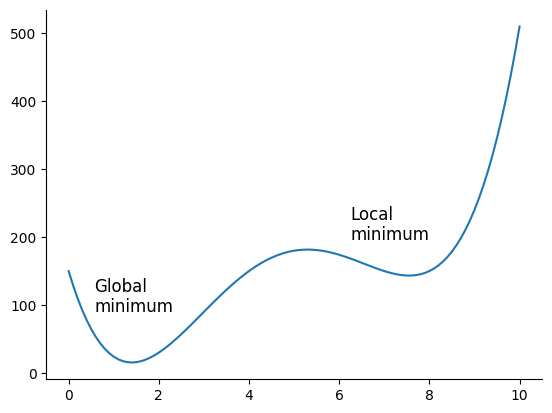

In [8]:
plot_loss()

Second, because the *loss* is defined over **the entire training set**: that's **expensive** to compute.

Even if we calculate the loss over **one example** at a time:

$$f = model, \theta = parameters, x = sample, y = label$$

$$
\bbox[5px,border:2px solid red]
{
Loss(f(x;\theta),y)
}
$$

We want to model not just one sample but a **whole dataset** of size $m$, the loss being an **average** over all samples $i$:


$$
\bbox[5px,border:2px solid red]
{
\DeclareMathOperator*{\argmax}{argmax} % thin space, limits underneath in displays
J(\theta) = \frac{1}{m}\sum_{i=1}^m Loss(f(x^i;\theta),y^i)
}
$$

We want to find parameters ($\theta$) that make this as small as possible.

#### The Rubik problem

Every time we calculate the gradient with respect to **one sample**, we are solving for just one side of the Rubik's.

Ideally, you'd want to make an update that improves your model for **all of your data** in one go.

In the *space of the loss function*, this is equivalent to have 'perfect' gradient: **know exactly** in which direction to step.

But there's way too much data! 

*Intuitively, perhaps you can think about this problem a bit like a Rubik's cube: you don't know which tweak is best to reach the solutions, so you tweak your machine to recognise 1s, which is a bit like solving for one face of the cube, but maybe as you do so, you realise that it now recognises 3s less. So you go on rectifying that, but then you lose on 7s, etc.*

We could call this the **Rubik problem**.

This is where gradient descent kicks in, solving our two problems:

1. We can improve our loss **without fully understanding its behaviour** (*landscape*).

2. The second is **stochastic**/**mini-batch** gradient descent, allowing us to **approximate  the gradient** using just a small batch of our data (one 'rubik face').

#### The landscape problem

As we have seen, the **loss** is a multivariate function taking **all the parameters** of the network as input.

The input space has **as many dimensions as the number of parameters (weights and biases)**.

Given the difficulty of the task, we take an **iterative** approach.

We start anywhere on that landscape, we improve things a tiny bit, and repeat.

If the input space of the loss is like a **multidimensional landscape**,

and each network parameter is a **dimension**,

the loss is our **ground height**,

the negative of the gradient gives us the **direction of steepest descent** (our *compas*)

and the update to our parameters is one step **downhill** to find a minimum.

<!-- <img style="height: 700px;" src="images/loss.landscape.jpeg"> -->
<img style="height: 700px;" src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/loss.landscape.jpeg?raw=true">

<small>Image Source: A. Amini et al. “[Spatial Uncertainty Sampling for End-to-End Control](https://arxiv.org/abs/1805.04829)”. *NeurIPS Bayesian Deep Learning 2018*</small>

### Gradient descent

$$
\bbox[5px,border:2px solid red]
{
    \begin{align*}
    w &= w - \eta \nabla_w f \\
    b &= b - \eta \nabla_b f
    \end{align*}
}
$$

In Python:

$$
\bbox[5px,border:2px solid red]
{
    \begin{align*}
    w\ &\mathrel{{-}{=}} eta * w\_gradient \\
    b\ &\mathrel{{-}{=}} eta * b\_gradient
    \end{align*}
}
$$

$\bf{\eta}$ **= step size =  learning rate**.

By convention, we make $w$ and $\nabla_w f$ the same shape (big tensors), so that the updates are applied *elementwise*.

<small>For reference, here's the official TensorFlow [Introduction to gradients and automatic differentiation](https://www.tensorflow.org/guide/autodiff).</small>

**If the step size is too small**, the ball might get stuck in a local minimum – never climbing the barrier between the minima. Also, it is **slow**.

**But if the step size is too large**, the ball might never find any minimum, it would just keep bouncing around, and could even diverge.

💀  There is **no way of knowing** the optimal step size because we never know what the loss landscape looks like. Must be tweaked!

<!-- <img style="height:300px;float:right;" src="images/imperial.learning_rate.svg"> -->
<img style="height:300px;float:right;" src="https://raw.githubusercontent.com/jchwenger/AI/d942b064df6d0e929cbd027bc6a6939f9e8fc763/2-building-blocks/images/imperial.learning_rate.svg">

<small style="position:absolute;bottom:0;right:0;">Source: [Imperial College Machine Learning - Neural Networks](https://www.doc.ic.ac.uk/~nuric/teaching/imperial-college-machine-learning-neural-networks.html)</small>

Research around optimizers is active, and focusses on solving these problems:

- How to learn **as fast as possible** (in particular, faster than SGD).

- How to avoid getting stuck in a **local optimum** (slightly less relevant for large nets.).

- How not to **overshoot** (you are near your goal and you go past it).

- How to move at different speeds in **different dimensions** (automatically).

- How to **minimize memory consumption**.

A key idea to improve vanilla SGD is **momentum**.

### Momentum

Momentum can be understood in two ways:

- from **physics**, with the ball on slope analogy: an acceleration is added to the velocity and the velocity is added to position.  
- as an **exponential moving average** (EMA) (where the previous gradients still have an influence on the current one).

<!-- <img style="height:500px" src="images/khandewal.momentum.png"> -->
<img style="height:500px" src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/khandewal.momentum.png?raw=true">

<small>[Harsh Khandewal, *Gradient Descent with Momentum, RMSprop And Adam Optimizer*, Medium](https://medium.com/analytics-vidhya/momentum-rmsprop-and-adam-optimizer-5769721b4b19)</small>

Particle dynamics:
    
$\begin{cases}
v(t + \Delta t) = v(t) + a(t) \Delta t\\
x(t + \Delta t) = x(t) + v(t) \Delta t
\end{cases}$
    
Or, with $\Delta t = 1$
    
$\begin{cases}
v(t + 1) = v(t) + a(t) \\
x(t + 1) = x(t) + v(t + 1)
\end{cases}$
    
   

The acceleration of a ball has two parts: friction and gradient.

$\color{red}{\alpha - 1}$: the coefficient of friction, values between 0 and 1.  
$\color{blue}{\eta } $: step size, aka learning rate.  
$\color{blue}{\nabla f}$: our gradient (*direction of steepest ascent*).  

\begin{align*}
a(t) = \color{red}{(\alpha - 1)}v(t) - \color{blue}{\eta \nabla f},\quad  \alpha \in [0, 1]
\end{align*}
    
\begin{align*}
\begin{cases}
\color{green}{v(t + 1)} &= v(t) + \color{red}{(\alpha - 1)}v(t)  - \color{blue}{\eta \nabla f} \\
         &= \color{red}{\alpha} v(t) - \color{blue}{\eta \nabla f}  & \leftarrow \color{red}{(\alpha - 1)}\ \text{simplifies} \\
x(t + 1) &= x(t) + \color{green}{v(t + 1)}
\end{cases}
\end{align*}

The negative gradient is the **downwards force** and the **opposing friction** is proportional to velocity.

Instead of this:

$$
\bbox[5px,border:2px solid red]
{
    \begin{align*}
    w &= w - \eta \nabla_w f \\
    \end{align*}
}
$$

We initialize $v_0$ with zeros, then do:

$$
\bbox[5px,border:2px solid red]
{
    \begin{cases}
        \begin{align*}
            v_t &= \alpha v_{t-1} - \eta \nabla_w f &&| \leftarrow \text{updating our velocity}\\
            w &= w + v_t &&| \leftarrow \text{updating our weights} \\
        \end{align*}
    \end{cases}
}
$$

$\bf{\eta}$ **= step size = learning rate**  
$\bf{\alpha}$ **= momentum coefficient**



<!-- $\begin{cases}
\Delta w(t + 1) = \alpha \Delta w(t) - \eta \nabla f  \\
w(t + 1) = w(t) + \Delta w(t + 1)
\end{cases}$
 -->

And similarly for $b$.

As pseudocode:

```python
delta_w = 0
loop:
    v = alpha * v - eta * gradient
    w = w + v
```

`eta` = `step_size` = `learning_rate`  
`alpha` = momentum coefficient

Another way of looking at the phenomenon: the current value being an **exponential moving average**.

Aka the **smoothing** of your values.

"If your gradient was big for a while, even if current values are low, it take some time to go down."

<!-- ![Ng exponentially weighted averages](images/andrew-ng-exponentially-weighted-averages.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/andrew-ng-exponentially-weighted-averages.png?raw=true">

<small>[Andrew Ng, Improving Deep Neural Networks: Hyperparameter Tuning, Regularization and Optimization (Course 2 of the Deep Learning Specialization)](https://www.youtube.com/watch?v=k8fTYJPd3_I&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=20).</small>

Instead of this:

$$
\bbox[5px,border:2px solid red]
{
    \begin{align*}
    w &= w - \eta \nabla_w f \\
    \end{align*}
}
$$
  
We initialize $v_0$ with zeros, then:

$$
\bbox[5px,border:2px solid red]
{
    \begin{cases}
        \begin{align*}
            v_t &= \beta v_{t-1} + (1 - \beta) \nabla_w f &&| \leftarrow \text{updating our EMA*}\\
            w &= w + \eta v_t &&| \leftarrow \text{updating our weights} \\
        \end{align*}
    \end{cases}
}
$$

$\bf{\eta}$ **= step size = learning rate**  
$\bf{\beta}$ **= smoothing coefficient**  
\* EMA: exponential moving average.

<!-- $\begin{cases}
\Delta w(t + 1) = \alpha \Delta w(t) - \eta \nabla f  \\
w(t + 1) = w(t) + \Delta w(t + 1)
\end{cases}$
 -->
  
And similarly for $b$.

*This is in fact just a scaled version of the previous equations, shifting the value of $\eta$.*


This is just scratching the surface on optimizers. Here are the most common:

1. **SGD with momentum**
(The less costly method, and the first developed historically, can outperform the ones below, but tricky/requires tuning)

2. **RMSProp**
(used by Chollet all the time, scales the gradient for each dimension)

3. **Adam**
(frankly, the most popular out there, literally 1 & 2 together!)

Great blog posts by Sebastian Ruder [here](https://ruder.io/optimizing-gradient-descent) and [here](https://ruder.io/deep-learning-optimization-2017).

### Recommended learning rate to start with

- `1e-4` (Chollet)
- #### `3e-4` (many others)

(In that ballpark: needs to be tweaked ⚙️.)

### Momentum for SGD: `0.9`.

Keras has all these default settings built-in.

You can check the default parameters [in the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers).

### Recommended playground

["Why Momentum Really Works", by Gabriel Oh, on Distill](https://distill.pub/2017/momentum/), with:
1. an interactive graph!
2. a lot of math, for those who crave that.

<!-- <a href="https://distill.pub/2017/momentum/"><img style="height:450px; float:right" src="images/gabriel-oh-momentum.png"></a> -->
<a href="https://distill.pub/2017/momentum/"><img style="height:450px; float:right" src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/gabriel-oh-momentum.png?raw=true"></a>

#### The Rubik's problem

The loss is the average of the losses for each sample in the entire training set (the **batch**).

Batch gradient descent gives us the true gradient but is still prohibitively expensive.

We can use the gradient for **one sample**, cheap but *high variance*, and iterate many times: **stochastic gradient descent**.

But there is a tradeoff!

We can calculate the loss and gradient for small, randomly selected subsets of the training set – **mini-batch (stochastic) gradient descent**.

Our gradient approximation is better, and the compute is manageable.

$$
	\qquad \qquad \qquad \underleftrightarrow{\bf{\text{batch} \qquad \qquad \qquad \text{mini-batch} \qquad \qquad \text{stochastic}}}
$$
$$
    \begin{array}{r|cc}
    \bf{\text{data}} & \text{whole dataset} \qquad & \text{a few samples}  & \qquad \text{one sample}\\
    \bf{\text{compute}} & \text{intractable} \qquad  &  \text{manageable}  &  \qquad \text{cheap}\\
    \bf{\text{gradient}} & \text{exact} \qquad  &  \text{intermediate}  &  \qquad \text{high variance}\\
    \end{array}
$$

Calculating the gradient on a mini-batch only will yield an **approximation** of the real gradient.

Better than a single sample, cheaper than the whole batch!

What we lose in precision, we gain in training speed!

💀 Guess what: **no magic formula** for the ideal batch size. Must be tweaked, depends on hardware.

##### Rule of thumb

If your batch size is big, your gradient is more accurate, so you can increase your learning rate! ⚙️ Tweak!

## Next

- 1. Derivatives
- 2. Derivatives for tensors: the gradient
- 3. Optimization: stochastic gradient descent, momentum
- 4. **Chaining derivatives: the backpropagation algorithm**

---

## Chaining derivatives: The Backpropagation algorithm

The gradient in SGD optimisers is calculated by an efficient organisation of the chain rule for differentiable loss and layer functions: **backpropagation**.

It is automatically implemented in TensorFlow.

The revolution of automatic differentiation (TensorFlow, PyTorch, JAX, etc.) is **all based on two principles**:

- Once you implement the derivative of an operation (`+`, or `*`, or anything more complex), it is **the same** wherever it appears (duh!, but this wouldn't be useful, if we didn't also have:);

- The chain rule means everything is **modular**: we only need to implement **local operations**, then we **chain** them together.


What does modular mean?

That each node only needs:
  - to know how to **compute the gradient** of its operation ("if the op is $x^2$, the gradient will be $2x$");
  - to know the **previous gradient(s)** flowing back from downward in the net;  
  - and **the values at the node during the forward pass** (they must be stored during the forward pass).
  

And that's it! With it you can calculate the gradient coming out, and pass it to the neurons upstream.

##### Note

If there is more than one branch coming in, the gradients are summed up!

<!-- ![Stanford backprop](images/stanford-backprop/backprop.13.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.13.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

What have we here: a node. It can be any operation combining the inputs $x$ and $y$ to obtain $z$.

This node knows how to compute $\frac{\partial z}{\partial x}$ and $\frac{\partial z}{\partial y}$.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.14.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.14.png?raw=true">

Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4

During backprop, information flows backward from the loss to the input: the node will receive $\frac{\partial L}{\partial z}$, *the gradient up to this point*, without knowing at all what the operations are or how it was computed. It just receives that number.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.15.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.15.png?raw=true">

Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4

Thanks to the chain rule, the node can then compute $\frac{\partial z}{\partial x}$ and multiply that by $\frac{\partial L}{\partial z}$ to obtain the gradient flowing in the $x$ direction, $\frac{\partial L}{\partial x}$.

##### Note

In order to compute $\frac{\partial z}{\partial x}$, the node needs to know what $x$ was in the forward pass!

<!-- ![Stanford backprop](images/stanford-backprop/backprop.16.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.16.png?raw=true">

Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4

And the same happens for $\frac{\partial L}{\partial y}$, multiplying $\frac{\partial L}{\partial z}$ by $\frac{\partial z}{\partial y}$, which amounts to *routing* the gradient information upstream!

This node has **no idea** how complex the whole network is!

It is only one cog in the big machine.

The most important things to understand:

- A neural net can be represented as a **(directed acyclic) graph** or **DAG** (several paths, but no loops), where information flows from input(s) to output(s), passing by a series of nodes (operations);

- When doing backprop, information flows **backward** through the network, computing the **influence** of each node on the loss!

- The chain rule says that if *if you know the gradient up to this point*, and the local gradient, you can move back one step by **multiplying** the incoming gradient with the current one;

<!-- ![Stanford backprop](images/stanford-backprop/backprop.01.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.01.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

Here is an example. Our equation is

$$
\begin{align*}
f(x, y, z) &= (x + y)z\\
\text{With:}&\\
x &= -2\\
y &= 5\\
z &= -4\\
\text{We have:}\\ -2 + 5 &= 3\\
3 * -4 &= -12
\end{align*}$$

<!-- ![Stanford backprop](images/stanford-backprop/backprop.02.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.02.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

All the partial derivatives have been calculated for us.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.03.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.03.png?raw=true">
<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

What is $\frac{\partial f}{\partial f}$?

<!-- ![Stanford backprop](images/stanford-backprop/backprop.04.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.04.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

One of course.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.05.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.05.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

Now what is $\frac{\partial f}{\partial z}$? On the left we have the derivative of the op: $\frac{\partial f}{\partial z} = q$.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.06.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.06.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

It is 3, that is $q$.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.07.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.07.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

Now what is $\frac{\partial f}{\partial q}$? The equation on the left tells us: $\frac{\partial f}{\partial q} = z$

<!-- ![Stanford backprop](images/stanford-backprop/backprop.08.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.08.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

It's -4.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.09.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.09.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

Now we can move further up. The gradient of additions is just one, so what does that node do? It multiplies the incoming gradient by 1.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.10.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.10.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

Which means the gradient at $y$ will also be -4.

<!-- ![Stanford backprop](images/stanford-backprop/backprop.12.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/2-building-blocks/images/stanford-backprop/backprop.12.png?raw=true">

<small>Source: [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/2017/syllabus.html), lecture 4</small>

And finally the same for $x$, -4.

##### Note

Several branches going 'back' into a node (i.e. if above we used `q` for several operations downstream) result in gradients **being summed together** (the mirror image of the summation in the forward pass).

#### A concrete example

The simplest example I could find for the **chain rule**, illustrating the gradient swap for multiplication.

$$ 🏃 \leftarrow_{2x} 🚲 \leftarrow_{3x} 🚗 \quad | \quad f=3y, y=2x$$


How much faster than me does the car go? 2 x 3, right?

The gradient for car-to-bike ($ \frac{df}{dy}  $) is 3, and bike-to-me ($ \frac{dy}{dx}  $) is  is 2 $\rightarrow$ the car-to-me ($ \frac{df}{dy}\frac{dy}{dx}$)  is 6.

What does that mean? It means that if I nudge **bike-to-me** by 1, the car-to-me goes up by 3 (the car-to-bike gradient):
- bike-to-me at 3 instead of 2 → car-to-me is now: $3 * 3 = 9\ (6 + 3)$

Conversely, if I nudge the **car-to-bike** by 1, car-to-me will be nudged by 2 (the bike-to-me gradient):

- car-to-bike at 4 instead of 3 → car-to-me is now: $2 * 4 = 8\ (6 + 2)$

Here is an [interactive website](https://webspace.ship.edu/msrenault/geogebracalculus/derivative_intuitive_chain_rule.html) allowing you to play with this!

---

### WE MADE IT

What does this all mean for us?

Automatic differentiation allows us to construct **arbitrary complex graphs of operations**.

And we don't need ever to do the mathematical derivation by hand!

This may not feel like it now, but this is **hugely** simplifying our lives.

---

## 3Blue1Brown summary

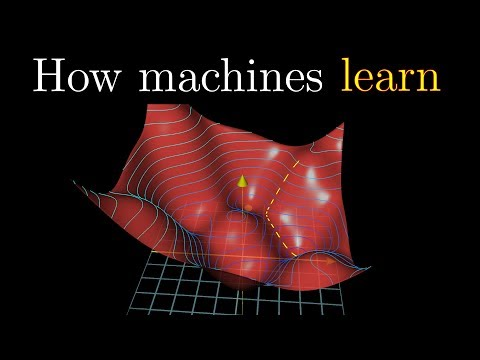

In [5]:
YouTubeVideo('IHZwWFHWa-w', width=853, height=480, start=109) # 3Blue1Brown 2, until 16'38

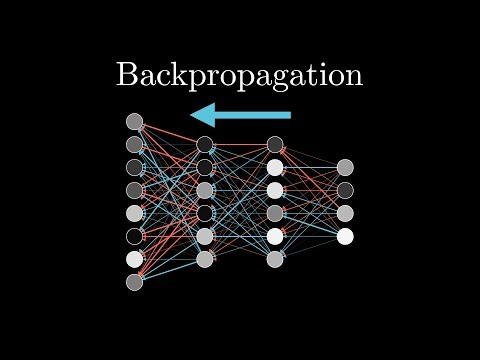

In [10]:
YouTubeVideo('Ilg3gGewQ5U', width=853, height=480, start=187) # 3Blue1Brown 3, until 12'30

---

# Looking back at our first example

**What we've seen:**

- Our first network;

- Tensors and their operations recap;

- SGD, differentiation and the chain rule.

All this for **that**??

In [11]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input((28 * 28, )))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [13]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Before training, our model performs poorly.

In [14]:
test_loss, test_acc = model.evaluate(test_images, test_labels) # testing before training
print()
print(test_acc, '(*μ_μ)')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1303 - loss: 2.3224

0.1339000016450882 (*μ_μ)


Then we train.

In [15]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8752 - loss: 0.4366
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9647 - loss: 0.1167
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9793 - loss: 0.0719
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9844 - loss: 0.0524
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9892 - loss: 0.0374


##### Note


There are $\lceil(60000 / 128)\rceil * 5 = 2345$ gradient updates for 5 epochs of 128 sample mini-batches.

The network is evaluated on the unseen test set. If successful, the trained model can be deployed.

In post office sorting rooms, for example.

In [16]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print()
print(test_acc, '(╯✧▽✧)╯')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9749 - loss: 0.0813

0.9782000184059143 (╯✧▽✧)╯


# Recap

**The Training Loop**

0. **Initialize** the weight and bias tensors with small random values.
1. Draw a **mini-batch** of training samples `x` and corresponding labels `y`.
2. **Forward pass**/**Inference**: the network makes a prediction `y_pred`.
3. **Loss**: Calculate how much `y_pred` differs from `y`.
4. **Backward pass**: using the gradient of the parameters with respect to the loss, update all parameters to lower the loss on this mini-batch.
5. Exit or return to 1.

Learning is the process of minimising the **predictive loss** of a model.

A neural network is trained by presenting **mini-batches** of samples and labels.

Network parameters are adjusted in order to **reduce the difference** between prediction and target.

The neural network implements a chain of **differentiable layer transformations**.

The loss-parmeter gradient is efficiently computed using the **chain rule**: the **backpropagation** algorithm.


The **optimizer** changes the parameters a small amount (our step) in the direction of the negative gradient.